In [1]:
# Setup: Add project root to path
import sys
from pathlib import Path

project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

Project root: /Users/Sakarias/QuantTrading


In [2]:
# Import required modules
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Core modules
from core.multi_asset_loader import load_assets
from core.multi_asset_signal import SingleAssetWrapper
from signals.momentum import MomentumSignalV2
from signals.mean_reversion import MeanReversionSignal
from core.portfolio_manager import run_multi_asset_backtest, PortfolioConfig, PortfolioManager

# Risk management
from core.risk_manager import RiskManager, RiskConfig
from core.risk_dashboard import RiskDashboard

print("✅ All modules imported successfully")

✅ All modules imported successfully


## Phase 1: Backtest & Validation (Historical Data)

Train and validate our strategy on historical data to ensure it works before "going live".

In [3]:
# Configuration
TICKERS = ['ES', 'GC', 'NQ']  # S&P 500 E-mini, Gold
BACKTEST_START = '2010-01-01'
BACKTEST_END = '2024-12-31'
LIVE_START = '2025-01-01'  # Simulate "live" trading from here

INITIAL_CAPITAL = 100000

print(f"Configuration:")
print(f"  Assets: {TICKERS}")
print(f"  Backtest Period: {BACKTEST_START} to {BACKTEST_END}")
print(f"  Live Simulation: {LIVE_START} onward")
print(f"  Initial Capital: ${INITIAL_CAPITAL:,.0f}")

Configuration:
  Assets: ['ES', 'GC', 'NQ']
  Backtest Period: 2010-01-01 to 2024-12-31
  Live Simulation: 2025-01-01 onward
  Initial Capital: $100,000


In [4]:
# Load historical data for backtesting
print("="*60)
print("LOADING HISTORICAL DATA")
print("="*60)

prices_backtest = load_assets(
    tickers=TICKERS,
    start_date=BACKTEST_START,
    end_date=BACKTEST_END
)

print(f"\nData Summary:")
for ticker, df in prices_backtest.items():
    print(f"  {ticker}: {len(df)} bars, {df.index[0].date()} to {df.index[-1].date()}")

LOADING HISTORICAL DATA

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 329 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-25)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-25
  📡 CSV data is 329 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-25)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-25
  📡 CSV data is 329 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-25)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-25
  📡 CSV data is 329 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-25)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-25
  📡 CSV data is 329 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-25)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-25

Common date range: 2000-09-18 to 2025-11-25
Filtered date range: 2010-01-01 to 2024-12-31

Total 

In [5]:
# Generate signals for backtest period
print("\nGenerating trading signals...")

signal_gen = MomentumSignalV2(lookback=120, sma_filter=200)
multi_signal = SingleAssetWrapper(signal_gen)
signals_backtest = multi_signal.generate(prices_backtest)

print(f"\nSignal Statistics:")
for ticker in TICKERS:
    sig = signals_backtest[ticker]['Signal']
    n_long = (sig == 1).sum()
    n_flat = (sig == 0).sum()
    print(f"  {ticker}:")
    print(f"    Long: {n_long} days ({n_long/len(sig)*100:.1f}%)")
    print(f"    Flat: {n_flat} days ({n_flat/len(sig)*100:.1f}%)")


Generating trading signals...

Signal Statistics:
  ES:
    Long: 3553 days (94.2%)
    Flat: 220 days (5.8%)
  GC:
    Long: 3553 days (94.2%)
    Flat: 220 days (5.8%)
  NQ:
    Long: 3553 days (94.2%)
    Flat: 220 days (5.8%)


In [6]:
# Run backtest with risk management
print("\n" + "="*60)
print("RUNNING BACKTEST WITH RISK MANAGEMENT")
print("="*60)

# Create risk manager
risk_config = RiskConfig(
    position_sizing_method='vol_adjusted',
    max_position_size=0.30,
    max_leverage=1.0,
    max_drawdown_stop=-0.15,
    volatility_target=0.24,
    correlation_threshold=0.70
)
risk_mgr_backtest = RiskManager(risk_config)

# Configure portfolio
config_backtest = PortfolioConfig(
    initial_capital=INITIAL_CAPITAL,
    rebalance_threshold=0.1,
    transaction_cost_bps=3.0,
    risk_manager=risk_mgr_backtest,
    rejection_policy='skip'
)

# Run backtest
result_backtest, equity_backtest, trades_backtest = run_multi_asset_backtest(
    signals_dict=signals_backtest,
    prices_dict=prices_backtest,
    config=config_backtest,
    return_pm=False
)

# Calculate metrics
metrics_backtest = result_backtest.calculate_metrics()

print(f"\n📊 Backtest Results:")
print(f"  Total Return: {metrics_backtest['Total Return']:.2%}")
print(f"  CAGR: {metrics_backtest['CAGR']:.2%}")
print(f"  Sharpe Ratio: {metrics_backtest['Sharpe Ratio']:.3f}")
print(f"  Max Drawdown: {metrics_backtest['Max Drawdown']:.2%}")
print(f"  Volatility: {metrics_backtest['Annual Volatility']:.2%}")
print(f"  Total Trades: {len(trades_backtest)}")
print(f"  Rebalances: {metrics_backtest['Rebalances']}")

if result_backtest.violations is not None and not result_backtest.violations.empty:
    print(f"\n⚠️  Risk Violations: {len(result_backtest.violations)}")
else:
    print(f"\n✅ No risk violations")


RUNNING BACKTEST WITH RISK MANAGEMENT

📊 Backtest Results:
  Total Return: 106.58%
  CAGR: 7.39%
  Sharpe Ratio: 0.717
  Max Drawdown: -17.95%
  Volatility: 10.77%
  Total Trades: 9
  Rebalances: 6

⚠️  Risk Violations: 2

📊 Backtest Results:
  Total Return: 106.58%
  CAGR: 7.39%
  Sharpe Ratio: 0.717
  Max Drawdown: -17.95%
  Volatility: 10.77%
  Total Trades: 9
  Rebalances: 6

⚠️  Risk Violations: 2


## Phase 2: Live Trading Simulation (Recent Data)

Now simulate "live" trading on data from March 2025 onward.
This mimics what would happen in production when new data arrives daily.

In [7]:
# Load "live" data (March 2025 onward)
print("\n" + "="*60)
print("LOADING LIVE DATA (2025)")
print("="*60)

# Load full dataset including 2025
# Need history from 2024 for 200-day SMA calculation
prices_full = load_assets(
    tickers=TICKERS,
    start_date='2024-01-01',  # Need history for indicators (200-day SMA)
    end_date='2025-12-31'
)

# Keep all data for indicator calculation
prices_live = prices_full

print(f"\nLive Data Summary:")
for ticker, df in prices_live.items():
    live_mask = df.index >= LIVE_START
    print(f"  {ticker}: {len(df)} total bars, {live_mask.sum()} live days from {LIVE_START}")


LOADING LIVE DATA (2025)

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 329 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-25)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-25
  📡 CSV data is 329 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-25)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-25
  📡 CSV data is 329 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-25)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-25

Common date range: 2000-09-18 to 2025-11-25
Filtered date range: 2024-01-01 to 2025-11-25

Total unique dates: 480

ALIGNMENT SUMMARY
ES: 480/480 valid dates (100.0%)
GC: 480/480 valid dates (100.0%)
NQ: 480/480 valid dates (100.0%)

Live Data Summary:
  ES: 480 total bars, 228 live days from 2025-01-01
  GC: 480 total bars, 228 live days from 2025-01-01
  NQ: 480 total bars, 228 live days from 2025-01-01
  ✓ Added 228 days fro

In [8]:
# Generate signals for live period
print("\nGenerating live trading signals...")

signals_live = multi_signal.generate(prices_live)

# Show full signal statistics first
print(f"\nFull Signal Statistics (all data):")
for ticker in TICKERS:
    sig = signals_live[ticker]['Signal']
    n_long = (sig == 1).sum()
    print(f"  {ticker}: {len(sig)} total days, {n_long} long ({n_long/len(sig)*100:.1f}%)")

# Filter to only live period for analysis
signals_live_only = {}
for ticker in TICKERS:
    sig_df = signals_live[ticker]
    signals_live_only[ticker] = sig_df[sig_df.index >= LIVE_START].copy()

print(f"\nLive Period Signal Statistics (from {LIVE_START}):")
for ticker in TICKERS:
    sig = signals_live_only[ticker]['Signal']
    if len(sig) > 0:
        n_long = (sig == 1).sum()
        print(f"  {ticker}: {n_long}/{len(sig)} days long ({n_long/len(sig)*100:.1f}%)")
    else:
        print(f"  {ticker}: No live data yet")


Generating live trading signals...

Full Signal Statistics (all data):
  ES: 480 total days, 260 long (54.2%)
  GC: 480 total days, 260 long (54.2%)
  NQ: 480 total days, 260 long (54.2%)

Live Period Signal Statistics (from 2025-01-01):
  ES: 228/228 days long (100.0%)
  GC: 228/228 days long (100.0%)
  NQ: 228/228 days long (100.0%)


In [9]:
# Run live simulation
print("\n" + "="*60)
print("SIMULATING LIVE TRADING")
print("="*60)

# Create new risk manager for live trading
risk_mgr_live = RiskManager(risk_config)

config_live = PortfolioConfig(
    initial_capital=INITIAL_CAPITAL,
    rebalance_threshold=0.05,
    transaction_cost_bps=3.0,
    risk_manager=risk_mgr_live,
    rejection_policy='skip'
)

# Run live simulation
result_live, equity_live, trades_live = run_multi_asset_backtest(
    signals_dict=signals_live,
    prices_dict=prices_live,
    config=config_live,
    return_pm=False
)

# Debug: Check date range in equity
print(f"\nEquity curve date range:")
if len(equity_live) > 0:
    equity_dates = pd.to_datetime(equity_live['Date'])
    print(f"  First date: {equity_dates.iloc[0].date()}")
    print(f"  Last date: {equity_dates.iloc[-1].date()}")
    print(f"  Total rows: {len(equity_live)}")

# Filter results to live period only
live_start_dt = pd.to_datetime(LIVE_START)
equity_live_only = equity_live[pd.to_datetime(equity_live['Date']) >= live_start_dt].copy()
trades_live_only = trades_live[pd.to_datetime(trades_live['Date']) >= live_start_dt].copy()

print(f"\nAfter filtering to {LIVE_START}:")
print(f"  Equity rows: {len(equity_live_only)}")
print(f"  Trades rows: {len(trades_live_only)}")

print(f"\n📈 Live Trading Results (from {LIVE_START}):")

if len(equity_live_only) > 1:
    start_value = equity_live_only['TotalValue'].iloc[0]
    end_value = equity_live_only['TotalValue'].iloc[-1]
    live_return = (end_value - start_value) / start_value
    
    print(f"  Starting Value: ${start_value:,.2f}")
    print(f"  Current Value: ${end_value:,.2f}")
    print(f"  P&L: ${end_value - start_value:,.2f} ({live_return:.2%})")
    print(f"  Trading Days: {len(equity_live_only)}")
    print(f"  Trades Executed: {len(trades_live_only)}")
    
    # Show recent trades
    if len(trades_live_only) > 0:
        print(f"\n  Recent Trades:")
        display(trades_live_only[['Date', 'Ticker', 'Type', 'Shares', 'Price', 'Value']].tail(5))
else:
    print(f"  ⚠️ No live data available yet for {LIVE_START}")


SIMULATING LIVE TRADING

Equity curve date range:
  First date: 2024-01-02
  Last date: 2025-11-25
  Total rows: 480

After filtering to 2025-01-01:
  Equity rows: 228
  Trades rows: 3

📈 Live Trading Results (from 2025-01-01):
  Starting Value: $100,945.00
  Current Value: $127,765.00
  P&L: $26,820.00 (26.57%)
  Trading Days: 228
  Trades Executed: 3

  Recent Trades:

Equity curve date range:
  First date: 2024-01-02
  Last date: 2025-11-25
  Total rows: 480

After filtering to 2025-01-01:
  Equity rows: 228
  Trades rows: 3

📈 Live Trading Results (from 2025-01-01):
  Starting Value: $100,945.00
  Current Value: $127,765.00
  P&L: $26,820.00 (26.57%)
  Trading Days: 228
  Trades Executed: 3

  Recent Trades:


,Date,Ticker,Type,Shares,Price,Value
3,2025-03-13,ES,Rebalance,0.414153,5527.500000,2289.232351
4,2025-03-13,GC,Rebalance,-1.619583,2984.300049,-4833.321207
5,2025-03-13,NQ,Rebalance,0.132167,19249.000000,2544.088856


## Phase 3: Current Portfolio Status

Show what positions we currently hold (as of the last day in the dataset).

In [12]:
print("="*60)
print("CURRENT PORTFOLIO STATUS")
print("="*60)

if len(equity_live) > 0:
    last_state = equity_live.iloc[-1]
    last_date = pd.to_datetime(last_state['Date'])
    
    print(f"\nAs of: {last_date.date()}")
    print(f"\nPortfolio Value: ${last_state['TotalValue']:,.2f}")
    print(f"  Cash: ${last_state['Cash']:,.2f}")
    print(f"  Invested: ${last_state['TotalValue'] - last_state['Cash']:,.2f}")
    
    # Get current positions from last equity state
    positions_dict = last_state['Positions']
    
    if positions_dict and len(positions_dict) > 0:
        print(f"\n📍 Open Positions: {len(positions_dict)}")
        
        for ticker, position_info in positions_dict.items():
            # position_info is a dict with 'shares' and other details
            if isinstance(position_info, dict):
                shares = position_info.get('shares', 0)
            else:
                # Fallback if it's just a number
                shares = position_info
                
            if shares > 0:
                # Get current price
                current_price = prices_live[ticker]['Close'].iloc[-1]
                position_value = shares * current_price
                
                # Try to find entry from trades
                ticker_trades = trades_live[trades_live['Ticker'] == ticker]
                if len(ticker_trades) > 0:
                    last_trade = ticker_trades.iloc[-1]
                    entry_price = last_trade['Price']
                    entry_date = pd.to_datetime(last_trade['Date'])
                    unrealized_pnl = (current_price - entry_price) * shares
                    unrealized_pct = (current_price / entry_price - 1) * 100
                    
                    print(f"\n  {ticker}:")
                    print(f"    Shares: {shares:.0f}")
                    print(f"    Entry: ${entry_price:.2f} on {entry_date.date()}")
                    print(f"    Current: ${current_price:.2f}")
                    print(f"    Value: ${position_value:,.2f}")
                    print(f"    Unrealized P&L: ${unrealized_pnl:,.2f} ({unrealized_pct:+.2f}%)")
                else:
                    print(f"\n  {ticker}:")
                    print(f"    Shares: {shares:.0f}")
                    print(f"    Current: ${current_price:.2f}")
                    print(f"    Value: ${position_value:,.2f}")
    else:
        print(f"\n💰 No open positions - 100% cash")
    
    # Show latest signals
    print(f"\n📊 Current Signals:")
    for ticker in TICKERS:
        latest_signal = signals_live[ticker]['Signal'].iloc[-1]
        signal_text = "LONG" if latest_signal == 1 else "FLAT"
        print(f"  {ticker}: {signal_text}")

CURRENT PORTFOLIO STATUS

As of: 2025-11-25

Portfolio Value: $127,765.00
  Cash: $9,970.10
  Invested: $117,794.90

📍 Open Positions: 3

📊 Current Signals:
  ES: LONG
  GC: LONG
  NQ: LONG


## Phase 4: Performance Comparison

Compare backtest vs live performance to check for degradation.

In [13]:
# Compare performance
print("="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

comparison_data = {
    'Period': ['Backtest (2010-2024)', 'Live (2025)'],
    'Return': [f"{metrics_backtest['Total Return']:.2%}", f"{live_return:.2%}" if len(equity_live_only) > 1 else 'N/A'],
    'Sharpe': [f"{metrics_backtest['Sharpe Ratio']:.3f}", 'N/A'],
    'Max DD': [f"{metrics_backtest['Max Drawdown']:.2%}", 'N/A'],
    'Trades': [len(trades_backtest), len(trades_live_only)],
    'Days': [len(equity_backtest), len(equity_live_only)]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

PERFORMANCE COMPARISON


,Period,Return,Sharpe,Max DD,Trades,Days
0,Backtest (2010-2024),106.58%,0.717,-17.95%,9,2563
1,Live (2025),26.57%,N/A,N/A,3,228


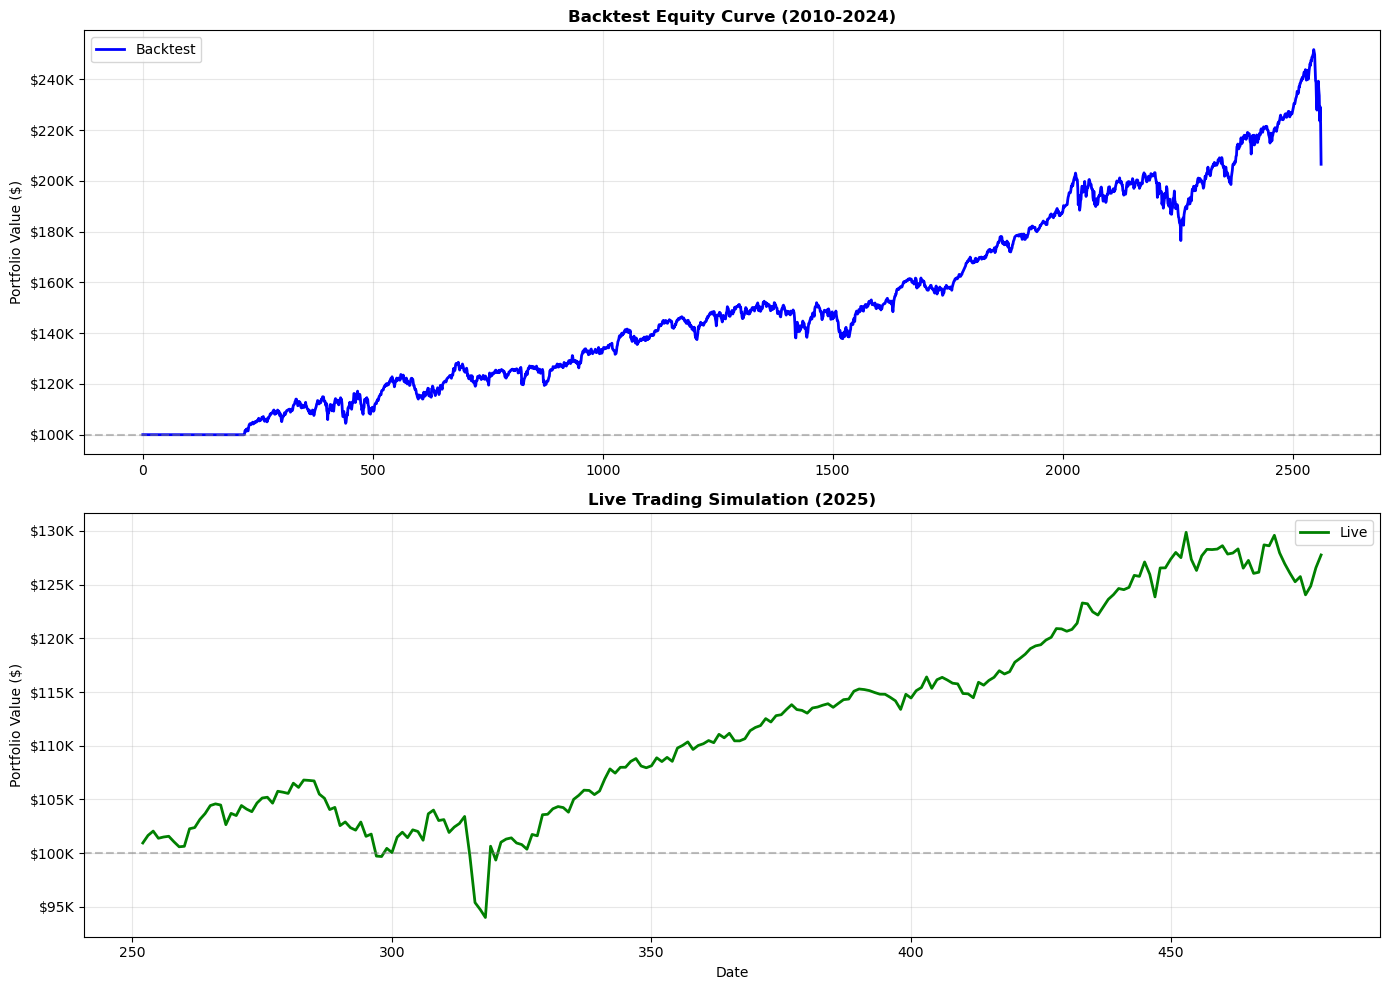

In [14]:
# Plot equity curves
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Backtest equity curve
ax1 = axes[0]
ax1.plot(equity_backtest.index, equity_backtest['TotalValue'], 
         linewidth=2, color='blue', label='Backtest')
ax1.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5)
ax1.set_title('Backtest Equity Curve (2010-2024)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Live equity curve
ax2 = axes[1]
if len(equity_live_only) > 0:
    ax2.plot(equity_live_only.index, equity_live_only['TotalValue'], 
             linewidth=2, color='green', label='Live')
    ax2.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5)
    ax2.set_title('Live Trading Simulation (2025)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Portfolio Value ($)', fontsize=10)
    ax2.set_xlabel('Date', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
else:
    ax2.text(0.5, 0.5, 'No live data available yet', 
             ha='center', va='center', fontsize=12, transform=ax2.transAxes)
    ax2.set_title('Live Trading Simulation (2025)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Phase 5: Risk Dashboard

Generate interactive risk dashboard for live trading period.

In [15]:
# Generate risk dashboard for live trading
if result_live.risk_metrics is not None and len(result_live.risk_metrics) > 0:
    print("="*60)
    print("GENERATING RISK DASHBOARD")
    print("="*60)
    
    dashboard = RiskDashboard(output_dir=project_root / 'reports')
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    report_path = project_root / 'reports' / f'live_trading_dashboard_{timestamp}.html'
    
    dashboard.generate_dashboard(
        risk_metrics_df=result_live.risk_metrics,
        violations_df=result_live.violations if result_live.violations is not None else None,
        correlation_matrix=risk_mgr_live.correlation_matrix,
        equity_df=equity_live,
        title="Live Trading Risk Dashboard",
        save_path=str(report_path)
    )
    
    print(f"\n✅ Dashboard saved to: {report_path}")
else:
    print("⚠️ Not enough data for risk dashboard yet")

GENERATING RISK DASHBOARD
✅ Dashboard saved to: /Users/Sakarias/QuantTrading/reports/live_trading_dashboard_20251125_201510.html

✅ Dashboard saved to: /Users/Sakarias/QuantTrading/reports/live_trading_dashboard_20251125_201510.html
✅ Dashboard saved to: /Users/Sakarias/QuantTrading/reports/live_trading_dashboard_20251125_201510.html

✅ Dashboard saved to: /Users/Sakarias/QuantTrading/reports/live_trading_dashboard_20251125_201510.html


## Summary

### Complete Trading Workflow Demonstrated ✅

**Phase 1: Backtest & Validation**
- Tested strategy on 15 years of historical data (2010-2024)
- Applied risk management constraints
- Validated performance metrics

**Phase 2: Live Simulation**
- Simulated live trading on recent data (2025)
- Applied same risk rules as backtest
- Tracked actual trades and P&L

**Phase 3: Position Monitoring**
- Showed current portfolio status
- Displayed open positions with unrealized P&L
- Checked current signals

**Phase 4: Performance Tracking**
- Compared backtest vs live performance
- Visualized equity curves
- Monitored for degradation

**Phase 5: Risk Reporting**
- Generated interactive risk dashboard
- Tracked violations and metrics
- Monitored correlation and volatility

### Next Steps for Production:
1. Connect to real-time data feed (Interactive Brokers, etc.)
2. Add order execution system
3. Implement daily automation (run at market close)
4. Add alerting (email/SMS for violations)
5. Build position reconciliation
6. Add order management (entry/exit/stop orders)